In [ ]:
import os, sys, time
import numpy as np
from numpy import sqrt, exp, pi, square
import pandas as pd
pd.options.mode.chained_assignment = None        # default='warn'
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d, UnivariateSpline
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm
from multiprocessing import Pool
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(plt, field)(eval(field))
    if isinstance(sci, str): plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): plt.colorbar(label=colorbar)
    elif colorbar: plt.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()

@contextmanager
def timeit():
    start = time.time()
    yield
    stop = time.time()
    print('This took %.2f seconds' % (stop-start))
    time.sleep(0.5)

In [ ]:
### hax ###
import hax
hax.__version__

hax.init(raw_data_access_mode = 'local',
         raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms/'], 
         main_data_paths= ['/project2/lgrandi/xenon1t/processed/pax_v6.8.0/',''],
         minitree_paths= ['/scratch/midway2/zhut/data/SingleScatter/data/minitrees/','/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/'],
         pax_version_policy = 'loose',
         use_rundb=False,
         make_minitree=False,
        )

In [ ]:
# For understanding background runs
run_name = '170419_0228'
my_dataset=8861

df = pd.read_pickle('/project2/lgrandi/zhut/data/compromise/pax_v6.8.0_none_sciencerun1_cpm/%s.pkl'%run_name)
df_long = df[df.eval('(s2>1e6) & (~CutS2Width)')]
df_normal = df[df.eval('(s2>1e6) & (CutS2Width)')]
df_deep = df[df.eval('(z_3d_nn<-80) & (s2 < 8000)')]

In [ ]:
# For reading pax configs
from pax import units
from pax import configuration

config_values = dict()

conf_ = hax.utils.combine_pax_configs(
    configuration.load_configuration(['_base']),
    configuration.load_configuration(['/home/zhut/fun_with_pax/pax/pax/config/_base'])
    )
for key in conf_.keys(): config_values.update(conf_[key])

conf_ = configuration.load_configuration(('XENON1T'))
for key in conf_.keys(): config_values.update(conf_[key])

conf_ = hax.utils.combine_pax_configs(
     configuration.load_configuration(['XENON1T']),
    hax.runs.get_run_info(my_dataset, 'processor'))
for key in conf_.keys(): config_values.update(conf_[key])

In [ ]:
class OriDesaturatePulses(plugin.TransformPlugin):
    """Estimates the waveform shape in channels that go beyond the digitizer's dynamic range, using
    the other channels' waveform shape as a template.
    See Fei & Yuehan's note: media=xenon:feigao:xenon1t_background_comparison_jan2017.html
    """

    def startup(self):
        self.reference_baseline = self.config['digitizer_reference_baseline']

    def transform_event(self, event):
        tpc_channels = np.array(self.config['channels_in_detector']['tpc'])

        # Boolean array, tells us which pulses are saturated
        is_saturated = np.array([p.maximum >= self.reference_baseline - p.baseline - 0.5
                                 for p in event.pulses])

        for pulse_i, pulse in enumerate(event.pulses):
            # Consider only saturated pulses in the TPC
            if not is_saturated[pulse_i] or pulse.channel not in tpc_channels:
                continue

            cap['p%d'%pulse_i] = dict()
            cap['p%d'%pulse_i]['before_desaturation']=self.waveform_in_pe(pulse).copy()
            cap['p%d'%pulse_i]['channel']=pulse.channel

            # Where is the current pulse saturated?
            saturated = pulse.raw_data <= 0            # Boolean array, True if sample is saturated
            _where_saturated = np.where(saturated)[0]
            try:
                first_saturated = _where_saturated.min()
                last_saturated = _where_saturated.max()
            except (ValueError, RuntimeError, TypeError, NameError):
                cap['p%d'%pulse_i]['original_desaturation']='first last sat'
                continue

            # Select a reference region just before the start of the saturated region
            reference_slice = slice(max(0, first_saturated - self.config['reference_region_samples']),
                                    first_saturated)
            # Find all pulses in TPC channels that overlap with the saturated & reference region
            other_pulses = [p for i, p in enumerate(event.pulses)
                            if p.left < last_saturated + pulse.left and p.right > pulse.left and
                            not is_saturated[i] and
                            p.channel in tpc_channels]

            if not len(other_pulses):
                # Rare case where no other pulses available, one channel going crazy?
                continue

            # Compute the (gain-weighted) sum waveform of the non-saturated pulses
            min_left = min([p.left for p in other_pulses + [pulse]])
            max_right = max([p.right for p in other_pulses + [pulse]])
            sumw = np.zeros(max_right - min_left + 1)
            for p in other_pulses:
                offset = p.left - min_left
                sumw[offset:offset + len(p.raw_data)] += self.waveform_in_pe(p)

            # Crop it to include just the part that overlaps with this pulse
            offset = pulse.left - min_left
            sumw = sumw[offset:offset + len(pulse.raw_data)]

            # Compute the ratio of this channel's waveform / the nonsaturated waveform in the reference region
            w = self.waveform_in_pe(pulse)
            if len(sumw[reference_slice][sumw[reference_slice] > 1]) < self.config['reference_region_samples_treshold']:
                # the pulse is saturated, but there are not enough reference samples to get a good ratio
                # This actually distinguished between S1 and S2 and will only correct S2 signals
                cap['p%d'%pulse_i]['original_desaturation']='ref sumw'
                continue

            ratio = w[reference_slice].sum()/sumw[reference_slice].sum()

            # not < is preferred over >, since it will catch nan
            if not ratio < self.config.get('min_reference_area_ratio', 1):
                # The pulse is saturated, but insufficient information is available in the other channels
                # to reliably reconstruct it
                cap['p%d'%pulse_i]['original_desaturation']='ratio'
                continue

            if len(w[reference_slice][w[reference_slice] > 1]) < self.config['reference_region_samples_treshold']:
                # the pulse is saturated, but there are not enough reference samples to get a good ratio
                # This actually distinguished between S1 and S2 and will only correct S2 signals
                cap['p%d'%pulse_i]['original_desaturation']='ref w'
                continue

            # Reconstruct the waveform in the saturated region according to this ratio.
            # The waveform should never be reduced due to this (then the correction is making things worse)
            # w[saturated] = np.clip(sumw[saturated] * ratio, w[saturated], float('inf'))
            
            result = w.copy()
            result[saturated] = np.clip(sumw[saturated] * ratio, w[saturated], float('inf'))
            cap['p%d'%pulse_i]['original_desaturation']=result

            # Convert back to raw ADC counts and store the corrected waveform
            # Note this changes the type of pulse.w from int16 to float64: we don't have a choice,
            # int16 probably can't contain the large amplitudes we may be putting in.
            # As long as the raw data isn't saved again after applying this correction, this should be no problem
            # (as in later code converting to floats is anyway the first step).
            # w /= adc_to_pe(self.config, pulse.channel)
            # w = self.reference_baseline - w - pulse.baseline

            #pulse.raw_data = w

        return event

    def waveform_in_pe(self, p):
        """Return waveform in pe/bin above baseline of a pulse"""
        w = self.reference_baseline - p.raw_data.astype(np.float) - p.baseline
        w *= adc_to_pe(self.config, p.channel)
        return w

In [ ]:
import numpy as np
from pax import plugin
from pax.dsputils import adc_to_pe


class ThisDesaturatePulses(plugin.TransformPlugin):
    """Estimates the waveform shape in channels that go beyond the digitizer's dynamic range, using
    the other channels' waveform shape as a template.

    See Fei & Yuehan's note: media=xenon:feigao:xenon1t_background_comparison_jan2017.html
    """

    def startup(self):
        self.reference_baseline = self.config['digitizer_reference_baseline']

    def transform_event(self, event):
        tpc_channels = np.array(self.config['channels_in_detector']['tpc'])

        # Boolean array, tells us which pulses are saturated
        is_saturated = np.array([p.maximum >= self.reference_baseline - p.baseline - 0.5
                                 for p in event.pulses])

        for pulse_i, pulse in enumerate(event.pulses):
            # Consider only saturated pulses in the TPC
            if not is_saturated[pulse_i] or pulse.channel not in tpc_channels:
                continue

            # Where is the current pulse saturated?
            saturated = pulse.raw_data <= 0            # Boolean array, True if sample is saturated
            _where_saturated_all = np.where(saturated)[0]

            # Split saturation if there is long enough non-saturated samples in between
            _where_saturated_diff = np.diff(_where_saturated_all, n=1)
            _where_saturated_diff = np.where(_where_saturated_diff > self.config['reference_region_samples'])[0]
            _where_saturated_list = np.split(_where_saturated_all, _where_saturated_diff+1)

            # Find all pulses in TPC channels that overlap with the saturated & reference region
            other_pulses = [p for i, p in enumerate(event.pulses)
                            if p.left < pulse.right and p.right > pulse.left and
                            not is_saturated[i] and
                            p.channel in tpc_channels and
                            not p.channel in self.config['large_after_pulsing_channels']]

            if not len(other_pulses):
                # Rare case where no other pulses available, one channel going crazy?
                cap['p%d'%pulse_i]['this_desaturation']='other pulses'
                continue

            for peak_i, _where_saturated in enumerate(_where_saturated_list):
                try:
                    first_saturated = _where_saturated.min()
                    last_saturated = _where_saturated.max()
                except (ValueError, RuntimeError, TypeError, NameError):
                    cap['p%d'%pulse_i]['this_desaturation']='first last'
                    continue

                """if len(_where_saturated) == 1:
                    cap['p%d'%pulse_i]['this_desaturation']='where saturated'
                    continue"""

                # Select a reference region just before the start of the saturated region
                reference_slice = slice(max(0, first_saturated - self.config['reference_region_samples']),
                                    first_saturated-1)

                # Compute the (gain-weighted) sum waveform of the non-saturated pulses
                min_left = min([p.left for p in other_pulses + [pulse]])
                max_right = max([p.right for p in other_pulses + [pulse]])
                sumw = np.zeros(max_right - min_left + 1)
                for p in other_pulses:
                    offset = p.left - min_left
                    sumw[offset:offset + len(p.raw_data)] += self.waveform_in_pe(p)

                # Crop it to include just the part that overlaps with this pulse
                offset = pulse.left - min_left
                sumw = sumw[offset:offset + len(pulse.raw_data)]

                # Compute the ratio of this channel's waveform / the nonsaturated waveform in the reference region
                w = self.waveform_in_pe(pulse)
                if len(sumw[reference_slice][sumw[reference_slice] > 1]) < self.config['reference_region_samples_treshold']:
                    # the pulse is saturated, but there are not enough reference samples to get a good ratio
                    # This actually distinguished between S1 and S2 and will only correct S2 signals
                    cap['p%d'%pulse_i]['this_desaturation']='ref sumw'
                    continue

                ratio = w[reference_slice].sum()/sumw[reference_slice].sum()

                # not < is preferred over >, since it will catch nan
                if not ratio < self.config.get('min_reference_area_ratio', 1):
                    # The pulse is saturated, but insufficient information is available in the other channels
                    # to reliably reconstruct it
                    cap['p%d'%pulse_i]['this_desaturation']='ref ratio'
                    continue

                if len(w[reference_slice][w[reference_slice] > 1]) < self.config['reference_region_samples_treshold']:
                    # the pulse is saturated, but there are not enough reference samples to get a good ratio
                    # This actually distinguished between S1 and S2 and will only correct S2 signals
                    cap['p%d'%pulse_i]['this_desaturation']='ref w'
                    continue

                # Finding individual section of wf for each peak
                # First end before the reference region of next peak
                start = max(0, first_saturated - self.config['reference_region_samples'])
                if peak_i+1 == len(_where_saturated_list):
                    end = len(w)
                else:
                    end = _where_saturated_list[peak_i+1][0]-self.config['reference_region_samples']

                # Second end before the first upwards turning point
                v = sumw[last_saturated: end]
                conv = np.ones(self.config['convolution_length'])/self.config['convolution_length']
                v = np.convolve(conv, v, mode='same')
                dv = np.diff(v, n=1)
                # Choose +2 pe/ns instead 0 to avoid ending on the flat waveform
                turning_point = np.where((np.hstack((dv, -10)) > 2) & (np.hstack((10, dv)) <= 2))[0]

                if len(turning_point)>0:
                    end = last_saturated + turning_point[0]

                # Determine where to stop correction
                # By checking the moving average of absolute deviation (MAAD) between raw and corrected pulse height
                deviation = np.abs(sumw[start:end]*ratio - w[start:end])
                size = int(min(self.config['convolution_length'], np.floor(end-start)/2))
                conv_half = np.concatenate([np.zeros(size), np.ones(size)/size])                
                deviation_moving_average = np.convolve(conv_half, deviation, mode='same')

                # Compare MAAD before and after the saturated peak
                try:
                    last_saturated = np.clip(np.arange(start, end+1), last_saturated, np.inf)
                    last_saturated = last_saturated[deviation_moving_average>deviation_moving_average[first_saturated-start]][-1]
                except:
                    last_saturated = end

                # Reconstruct the waveform in the saturated region according to this ratio.
                # The waveform should never be reduced due to this (then the correction is making things worse)
                saturated_to_correct = np.arange(first_saturated, last_saturated)
                w[saturated_to_correct] = np.clip(sumw[saturated_to_correct] * ratio, 0, float('inf'))

                # Convert back to raw ADC counts and store the corrected waveform
                # Note this changes the type of pulse.w from int16 to float64: we don't have a choice,
                # int16 probably can't contain the large amplitudes we may be putting in.
                # As long as the raw data isn't saved again after applying this correction, this should be no problem
                # (as in later code converting to floats is anyway the first step).
                w /= adc_to_pe(self.config, pulse.channel)
                w = self.reference_baseline - w - pulse.baseline

                pulse.raw_data = w
            
            result = self.waveform_in_pe(pulse).copy()
            cap['p%d'%pulse_i]['this_desaturation']=result

        return event

    def waveform_in_pe(self, p):
        """Return waveform in pe/bin above baseline of a pulse"""
        w = self.reference_baseline - p.raw_data.astype(np.float) - p.baseline
        w *= adc_to_pe(self.config, p.channel)
        return w

In [ ]:
from pax.plugins.signal_processing import CheckPulses, PulseProperties, DesaturatePulses, HitFinder, BuildPeaks, SumWaveform
from pax.plugins.peak_processing import RejectNoiseHits, LocalMinimumClustering, NaturalBreaksClustering

import pprint

class SignalProcessing(plugin.TransformPlugin):
    """
    I use this class to test all the plugins.
    If you look at plugin.TransformPlugin you will see that to init
    you will need to put in (self, config_values, processor)
    """
    
    def transform_event(self, event, switch_out=False):
        """Frist config values from XENON1T.ini provides the order of original plugins """
        run_till_step = 3
        plugin_list = self.config['dsp'][:run_till_step]
        
        for ix, p in enumerate(plugin_list):
            p = eval(p)(self.config, self.processor)
            p.transform_event(event)
        
        return event

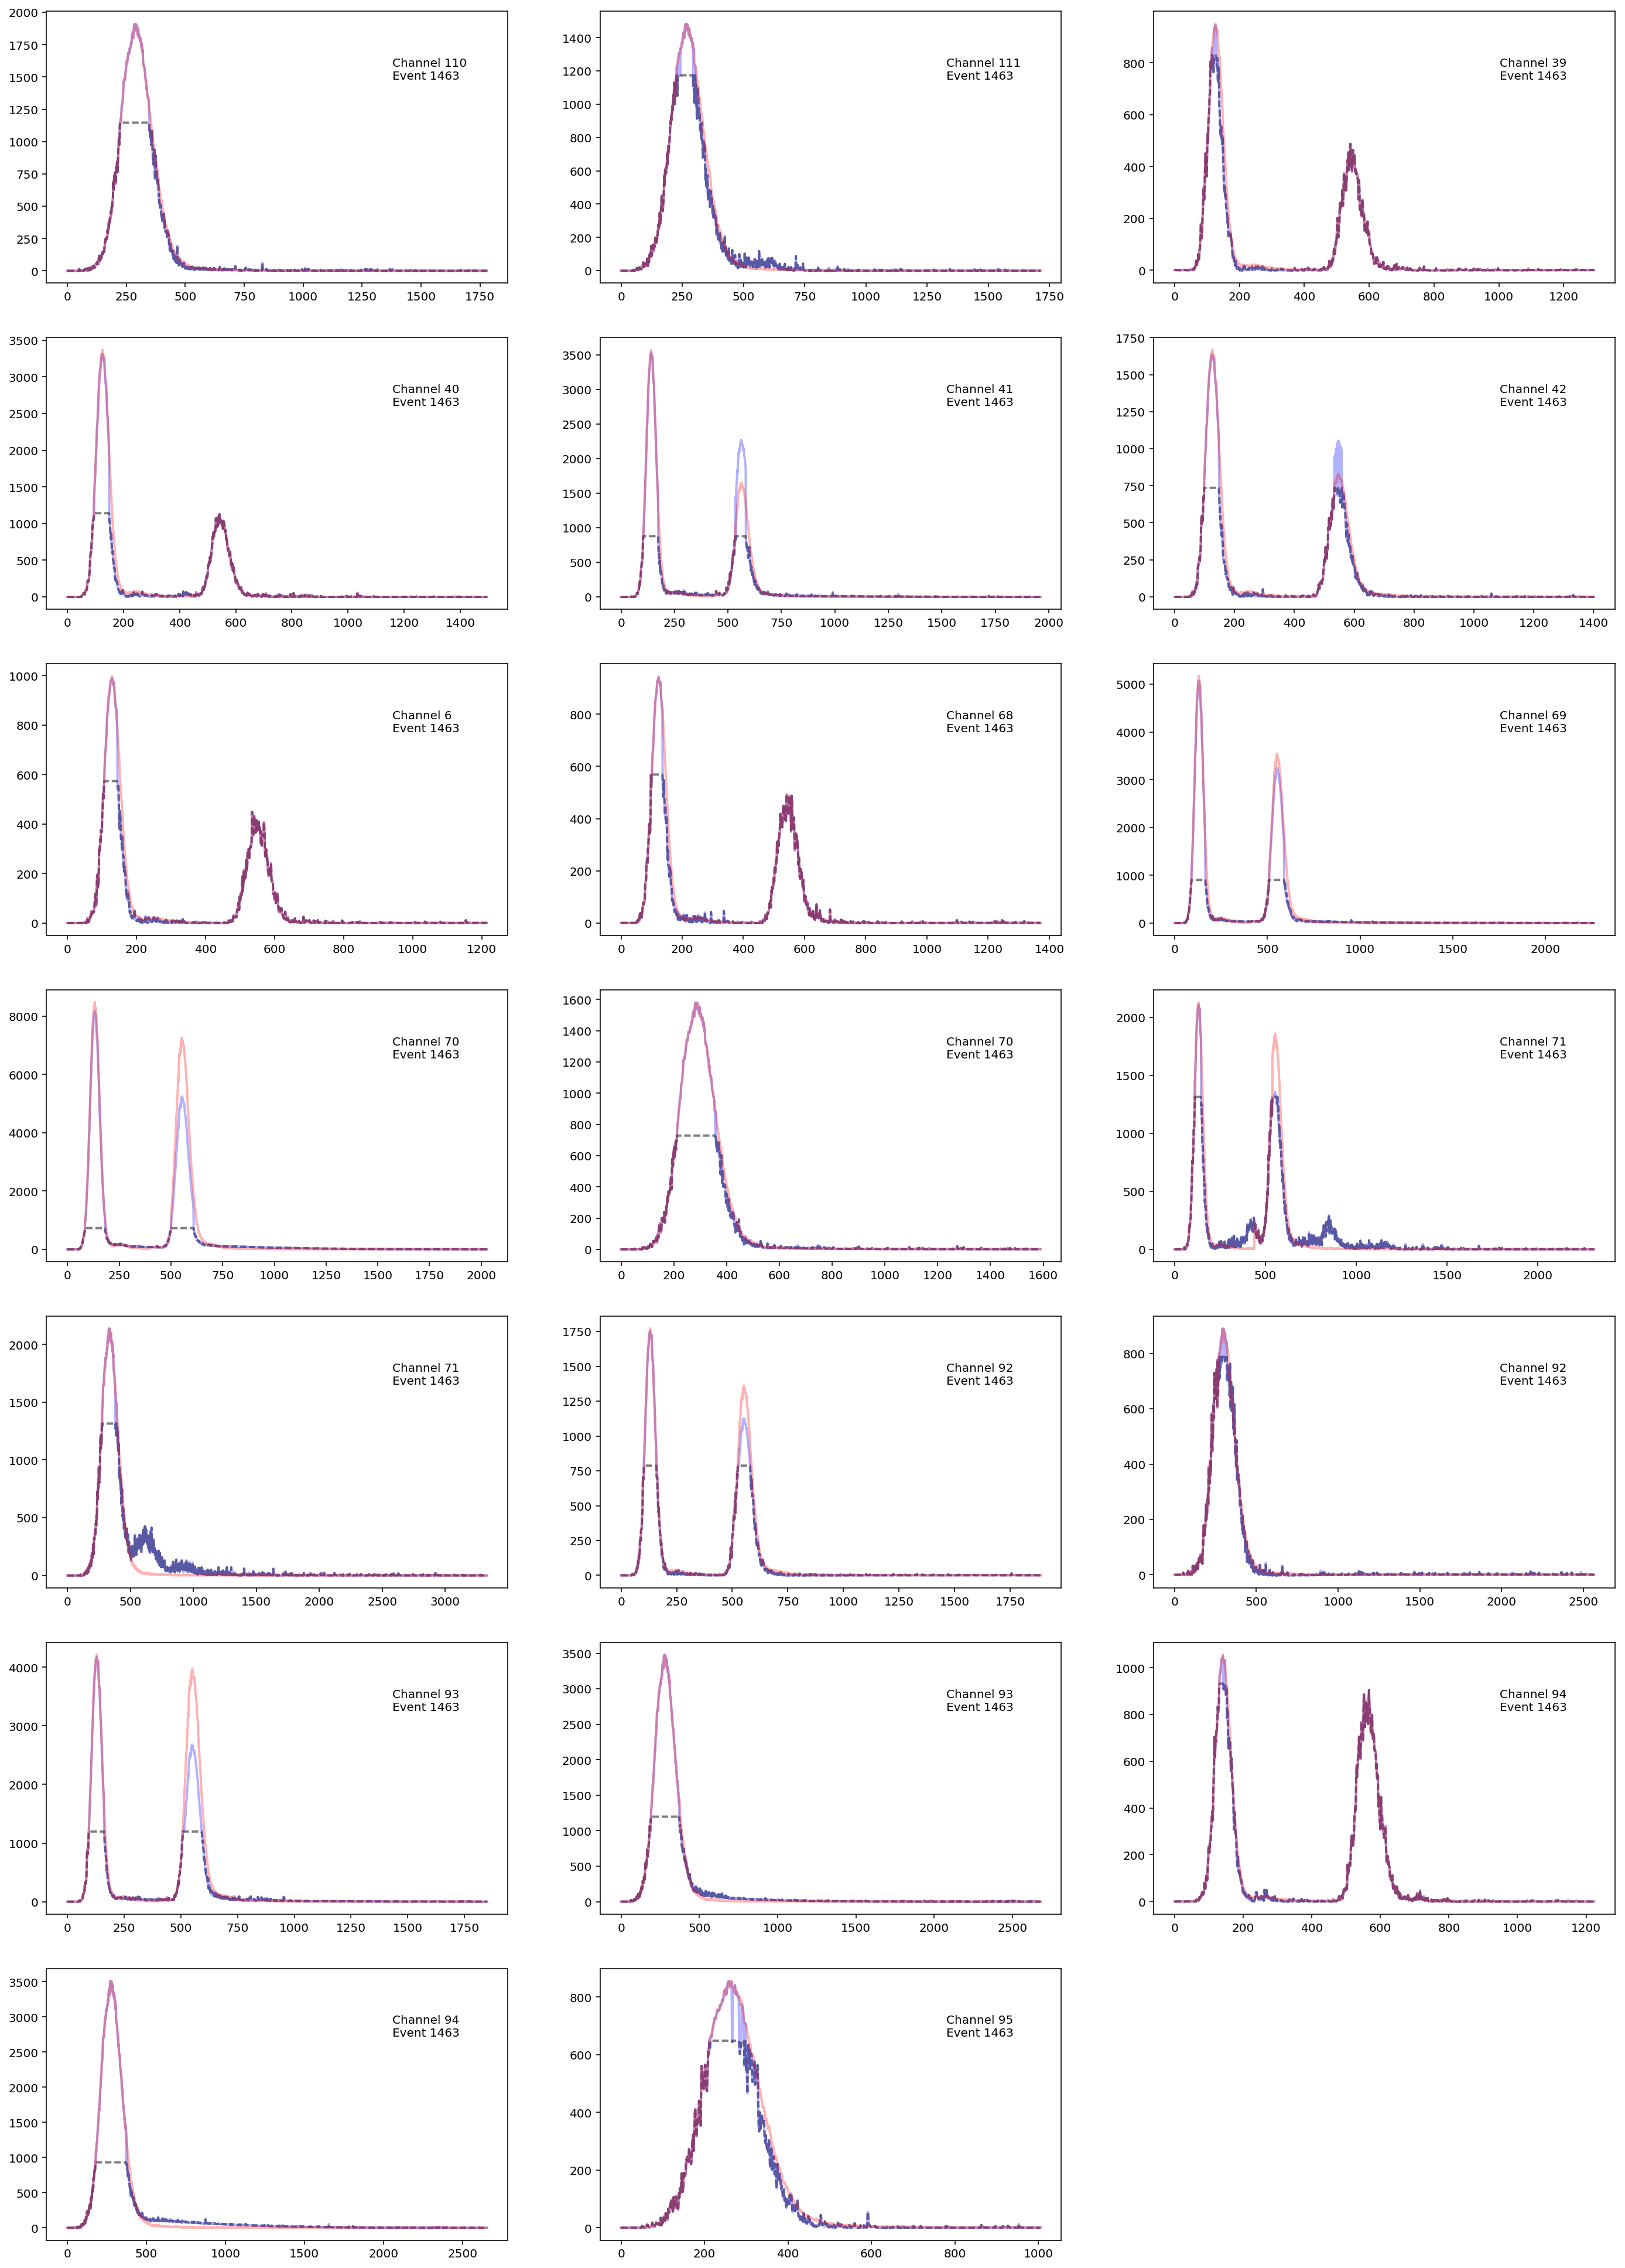

In [ ]:
def plot_saturation(run_name, event_number):
    total_plots = len(cap.keys())
    if total_plots<3:
        return 0
    total_plots = min(total_plots, 30)
    rows = int(np.ceil(total_plots/3))

    with initiate_plot(24, 5*rows):
        keys = list(cap.keys())
        keys.sort()
        
        for ix, key in enumerate(keys):
            if ix==30: break
            ax = fig.add_subplot(rows,3,1+ix)
            original = cap[key]['original_desaturation']
            this = cap[key]['this_desaturation']
            before = cap[key]['before_desaturation']
            
            
            xaxis = np.arange(len(before))
            plt.plot(xaxis, before*10, color='k', ls='--', alpha=.5, lw=2.0)
            if isinstance(original, str):
                plt.text(.55, .55, 'Problem with %s'%original, transform=ax.transAxes)
            else:
                plt.plot(xaxis, original*10, color='b', alpha=.3, lw=2.0)
                
            if isinstance(this, str):
                plt.text(.55, .45, 'Problem with %s'%this, transform=ax.transAxes)
            else:
                plt.plot(xaxis, this*10, color='r', alpha=.3, lw=2.0)
            
            plt.text(.75, .75, 'Channel %d\nEvent %d'%(cap[key]['channel'], event_number),
                     transform=ax.transAxes)

        plt.savefig('/home/zhut/fun_with_pax/desaturation/%s_e%d.pdf'%(run_name, event_number), 
        dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)
        
event_numbers = df.event_number.values
events = hax.raw_data.raw_events(my_dataset, event_numbers = event_numbers)
for jx in range(200): 
    event = next(events)

    cap = dict() # Remember, this is my backdoor to take something out.
    p = SignalProcessing(config_values, 0)
    event = p.transform_event(event, switch_out=True) # xlim is just for plotting range.
    
    p = OriDesaturatePulses(config_values, 0)
    event = p.transform_event(event)
    
    p = ThisDesaturatePulses(config_values, 0)
    event = p.transform_event(event)
    
    print('event %d' % event_numbers[jx])
    plot_saturation(run_name, event_numbers[jx])